In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

### **Reconstructing by autoencoder**

In [2]:
# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Input scaling
x_train_scaled = x_train.astype('float32') / 255
x_test_scaled = x_test.astype('float32') / 255

In [4]:
# Reshape input
x_train = x_train_scaled.reshape((60000, 28*28))
x_test = x_test_scaled.reshape((10000, 28*28))

In [5]:
# Build autoencoder
input_size = 784    # dimension of input vector (28 * 28)
hidden_size = 128
code_size = 32      # dimension of latent vector

input_img = Input(shape=(input_size,))                          # input layer
hidden_1 = Dense(hidden_size, activation='relu')(input_img)     # encoding
code = Dense(code_size, activation='relu')(hidden_1)            # latent space
hidden_2 = Dense(hidden_size, activation='relu')(code)          # decoding
output_img = Dense(input_size, activation='sigmoid')(hidden_2)  # output layer

autoencoder = Model(input_img, output_img)

In [6]:
# Compile
autoencoder.compile(optimizer='adam', loss='mse')

In [7]:
# Fit the model
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 15s 7ms/step - loss: 0.0261
Epoch 2/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0133
Epoch 3/5
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0117
Epoch 4/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0107
Epoch 5/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0101


In [8]:
# Evaluate the model
test_mse = autoencoder.evaluate(x_test, x_test)
print(f'Test MSE: {test_mse:.8f}')

313/313 [==============================] - 1s 3ms/step - loss: 0.0096
Test MSE: 0.00958692


In [9]:
# Predict image
decoded_imgs = autoencoder.predict(x_test)
decoded_imgs = decoded_imgs.reshape((10000, 28, 28))

313/313 [==============================] - 1s 3ms/step


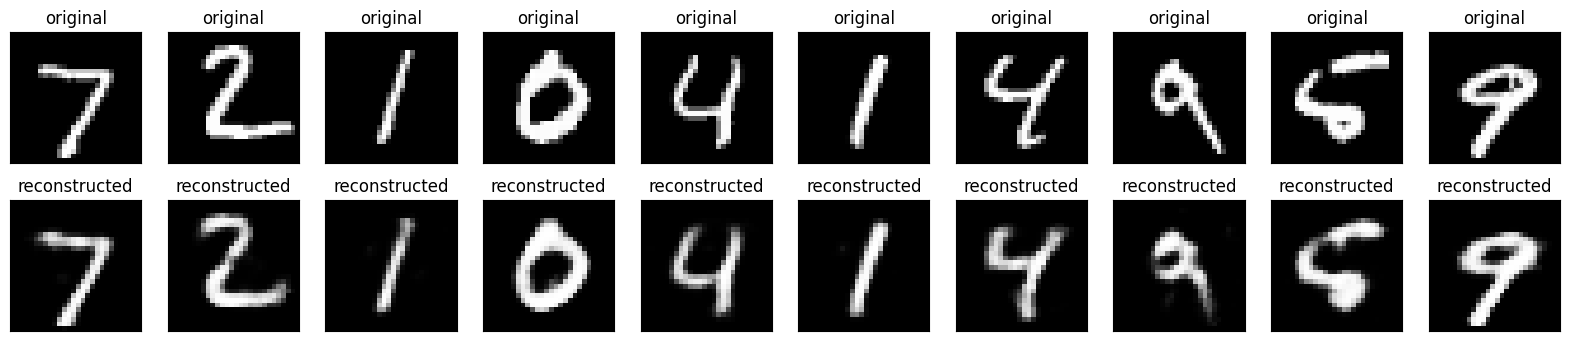

In [10]:
# Compare original image and predicted image
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # original image
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_scaled[i])
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # decoded image
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### **Classification by representation vector**

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
import numpy as np

In [12]:
# Use only encoder
encoder = Model(inputs=input_img, outputs=code)

In [13]:
# Create low dimensional vector
x_train_encode = encoder.predict(x_train)
x_test_encode = encoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [14]:
# One-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [15]:
# Build a classification model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train_encode.shape[1],)))
model.add(Dense(10, activation='softmax'))

In [16]:
# Compile
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Fit the model
history = model.fit(x_train_encode, y_train_one_hot, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
375/375 [==============================] - 2s 3ms/step - loss: 0.7236 - accuracy: 0.7836 - val_loss: 0.3519 - val_accuracy: 0.8939
Epoch 2/20
375/375 [==============================] - 1s 2ms/step - loss: 0.3378 - accuracy: 0.8950 - val_loss: 0.3044 - val_accuracy: 0.9042
Epoch 3/20
375/375 [==============================] - 1s 3ms/step - loss: 0.2782 - accuracy: 0.9150 - val_loss: 0.2276 - val_accuracy: 0.9317
Epoch 4/20
375/375 [==============================] - 2s 6ms/step - loss: 0.2350 - accuracy: 0.9269 - val_loss: 0.2036 - val_accuracy: 0.9393
Epoch 5/20
375/375 [==============================] - 2s 4ms/step - loss: 0.2060 - accuracy: 0.9369 - val_loss: 0.1809 - val_accuracy: 0.9463
Epoch 6/20
375/375 [==============================] - 1s 3ms/step - loss: 0.1860 - accuracy: 0.9433 - val_loss: 0.1792 - val_accuracy: 0.9472
Epoch 7/20
375/375 [==============================] - 1s 3ms/step - loss: 0.1699 - accuracy: 0.9486 - val_loss: 0.1535 - val_accuracy: 0.9542
Epoch 

In [18]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test_encode, y_test_one_hot)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

313/313 [==============================] - 1s 2ms/step - loss: 0.1119 - accuracy: 0.9648
Test loss: 0.1119
Test accuracy: 0.9648


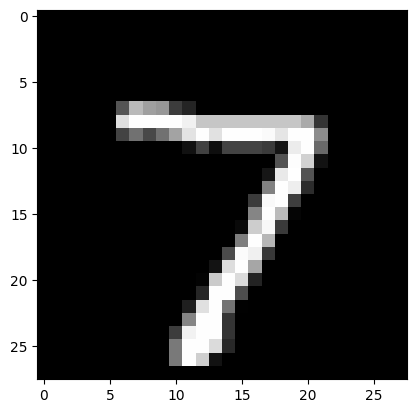

True value: 7
1/1 [==============================] - 0s 30ms/step
Predicted value: 7


In [23]:
# Compare the true value and predicted value
# true value
plt.imshow(x_test_scaled[0], cmap='gray')
plt.show()
print('True value:', y_test[0])

# predicted value
np.set_printoptions(suppress=True, precision=10)
prediction = model.predict(x_test_encode[0:1])
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print('Predicted value:', labels[np.argmax(prediction)])